# **HW3**
**Name:** Janga Tushita Sharva  
**Roll Number:** CS21BTECH11022

In [71]:
import numpy as np
import matplotlib.pyplot as plt

### **Data Sets generation**

In [72]:
def generate_data_points(N):
    return np.random.randint(2, size=(N, 2)).astype(float)

def generate_xor_dataset(datapoints):
    y_xor = np.array([np.logical_xor(x1, x2) for x1, x2 in datapoints])
    noise_x1 = np.random.normal(0, 0.01, len(datapoints))
    noise_x2 = np.random.normal(0, 0.01, len(datapoints))
    # add noise to the datapoints
    for i in range(len(datapoints)):
        datapoints[i][0] += noise_x1[i]
        datapoints[i][1] += noise_x2[i]
    return datapoints, y_xor

def generate_and_dataset(datapoints):
    y_and = np.array([np.logical_and(x1, x2) for x1, x2 in datapoints])
    noise_x1 = np.random.normal(0, 0.1, len(datapoints))
    noise_x2 = np.random.normal(0, 0.1, len(datapoints))
    # add noise to the datapoints
    for i in range(len(datapoints)):
        datapoints[i][0] += noise_x1[i]
        datapoints[i][1] += noise_x2[i]
    return datapoints, y_and

def generate_or_dataset(datapoints):
    y_or = np.array([np.logical_or(x1, x2) for x1, x2 in datapoints])
    noise_x1 = np.random.normal(0, 0.01, len(datapoints))
    noise_x2 = np.random.normal(0, 0.01, len(datapoints))
    # add noise to the datapoints
    for i in range(len(datapoints)):
        datapoints[i][0] += noise_x1[i]
        datapoints[i][1] += noise_x2[i]
    return datapoints, y_or

In [73]:
X_xor, y_xor = generate_xor_dataset(generate_data_points(10000))
X_and, y_and = generate_and_dataset(generate_data_points(10000))
X_or, y_or = generate_or_dataset(generate_data_points(10000))

## Aritifical Neural Network
$$
\begin{align*}
\mathbf{\hat{y}} &= g\left(\mathbf{W}^{(2)} \sigma(\mathbf{W}^{(1)} \mathbf{x} + \mathbf{b}^{(1)}) + \mathbf{b}^{(2)}\right) \\
\end{align*}
$$

$\mathbf W^{(1)}, \mathbf b^{(1)}$: parameters of the first layer, 
$\mathbf W^{(1)}, \mathbf b^{(2)}$ are the parameters of the second layer,  

Here we are performing a binary classification task, so $g(\cdot)$ can be the sigmoid function. We take the activation function to also be the sigmoid function.

The loss function is the squared error loss, which is given as:
$$  
\begin{align*}
\mathcal L(\mathbf{y}, \mathbf{\hat{y}}) &= \frac{1}{n} \sum_{i=1}^n \left(y^{(i)} - \hat{y}^{(i)}\right)^2
\end{align*}
$$

For gradient, we need to differentiate WRT parameters. As derived from the class, we get

$$\frac{\partial \mathcal L}{\partial \mathbf{W}^{(2)}} = -{2\over n}\sum_{i=1}^n {\left(y^{(i)} - \hat y^{(i)}\right)} {g'\left(\mathbf h_2^{(i)}\right)}\sigma\left(\mathbf{h}
_{1}^{(i)}\right)$$

where $\mathbf{h}_{1}^{(i)} = \mathbf{W}^{(1)} \mathbf{x}^{(i)} + \mathbf{b}^{1}$ and $\mathbf{h}_{2}^{(i)} = \mathbf{W}^{(2)}\sigma\left(\mathbf{h}_{1}^{(i)}\right) + \mathbf{b}^{(2)}$.


$$\frac{\partial \mathcal L}{\partial \mathbf{W}^{(1)}} = -{2\over n}\sum_{i=1}^n {\left(y^{(i)} - \hat y^{(i)}\right)} g'\left(\mathbf h_2^{(i)}\right) \left(\mathbf W^{(2)}\odot \sigma'\left(\mathbf h_{1}^{(i)}\right)\right)\otimes\mathbf x^{(i)}$$

and  

$$\theta^{(r)} = \theta^{(r-1)} - \eta \cdot \nabla_{\theta^{r-1}} L(\theta)$$

In [74]:
class ANN():

    def __init__(self, input_size, hidden_size, output_size, random_state=42):
        np.random.seed(random_state)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # initialize weights and biases
        # the formula would be y_pred = sigmoid((sigmoid(input_weights @ X + input_bias)) @ output_weights + output_bias)
        self.input_weights = np.random.randn(self.input_size, self.hidden_size)
        self.output_weights = np.random.randn(self.hidden_size, self.output_size)
        self.input_bias = np.random.randn(self.hidden_size, 1)
        self.output_bias = np.random.randn(self.output_size, 1)

        self.hidden_outputs = None # required for backprop step
        self.output_outputs = None # required for backprop step
        self.y_pred = None

        self.losses_batch_wise = []
        self.losses_epoch_wise = []
        self.accuracies_batch_wise = []
        self.accuracies_epoch_wise = []

        self.loss_test = []
        self.accuracies_test = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        sigm = self.sigmoid(x)
        return sigm * (1 - sigm)
    
    def forward(self, x):
        # hidden outputs = matrix_mult of input_weights and x + input_bias
        self.hidden_outputs = self.input_weights @ x.T + self.input_bias # transpose because each x is in row

        # output_outputs = matrix_mult of output_weights and sigmoid of hidden_outputs + output_bias
        self.output_outputs = self.output_weights.T @ self.sigmoid(self.hidden_outputs) + self.output_bias
        # y_pred = sigmoid of output_outputs
        self.y_pred = self.sigmoid(self.output_outputs)
        return self.y_pred
    
    def backward(self, x, y, learning_rate=0.01):
        error_output = (-1 / len(y)) * (y - self.y_pred) * self.sigmoid_derivative(self.output_outputs)  # shape: (output_size, batch_size)
        
        derivative_output_weights = error_output @ self.sigmoid(self.hidden_outputs).T  # shape: (output_size, hidden_size)
        error_hidden = (self.output_weights @ error_output) * self.sigmoid_derivative(self.hidden_outputs)  # shape: (hidden_size, batch_size)
        
        derivative_hidden_weights = error_hidden @ x  # shape: (hidden_size, input_size)
        
        # Update weights and biases
        self.output_weights -= learning_rate * derivative_output_weights.T
        self.input_weights -= learning_rate * derivative_hidden_weights
        self.output_bias -= learning_rate * np.mean(error_output, axis=1, keepdims=True)
        self.input_bias -= learning_rate * np.mean(error_hidden, axis=1, keepdims=True)

    def loss(self, y, y_pred):
        return 0.5 * np.mean((y - y_pred)**2)
    
    def accuracy(self, y, y_pred):
        return np.mean(y == np.round(y_pred).astype(np.int32))
    
    # 80% data for training and 20% for testing
    def test_train_split(self, X, y):
        split = int(len(X) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        return X_train, X_test, y_train, y_test
    
    def train(self, X, y, epochs, learning_rate, batch_size_percent=0.1):
        X_train, X_test, y_train, y_test = self.test_train_split(X, y)
        batch_size = int(len(X_train) * batch_size_percent)

        for epoch in range(epochs):
            for i in range(0, len(X_train), batch_size):
                x_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                self.y_pred = self.forward(x_batch)

                self.backward(x_batch, y_batch, learning_rate)
                self.losses_batch_wise.append(self.loss(y_batch, self.y_pred))
                self.accuracies_batch_wise.append(self.accuracy(y_batch, self.y_pred))

            self.losses_epoch_wise.append(np.mean(self.losses_batch_wise))
            self.accuracies_epoch_wise.append(np.mean(self.accuracies_batch_wise))

            # evaluate on test data
            self.evaluate(X_test, y_test)      
        
    
    def evaluate(self, X_test, y_test):
        y_pred = self.forward(X_test)
        loss = self.loss(y_test, self.y_pred)
        accuracy = self.accuracy(y_test, self.y_pred)
        self.loss_test.append(loss)
        self.accuracies_test.append(accuracy)

In [75]:
def plot_losses_accuracies(ann, n, batch_size_percentage):
    # plot 6 subplots batchwise, epochwise, test loss and accuracies
    fig, axs = plt.subplots(2, 3, figsize=(11, 5.5))

    # Plot losses batch wise
    axs[0, 0].plot(ann.losses_batch_wise)
    axs[0, 0].set_title('Losses Batch Wise')
    axs[0, 0].set_xlabel('Batch')
    axs[0, 0].set_ylabel('Loss')

    # Plot accuracies batch wise
    axs[1, 0].plot(ann.accuracies_batch_wise)
    axs[1, 0].set_title('Accuracies Batch Wise')
    axs[1, 0].set_xlabel('Batch')
    axs[1, 0].set_ylabel('Accuracy')

    # Plot losses epoch wise
    axs[0, 1].plot(ann.losses_epoch_wise)
    axs[0, 1].set_title('Losses Epoch Wise')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    
    # Plot accuracies epoch wise
    axs[1, 1].plot(ann.accuracies_epoch_wise)
    axs[1, 1].set_title('Accuracies Epoch Wise')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Accuracy')

    # Plot test loss
    axs[0, 2].plot(ann.loss_test)
    axs[0, 2].set_title('Test Loss')
    axs[0, 2].set_xlabel('Epoch')
    axs[0, 2].set_ylabel('Loss')

    # Plot test accuracies
    axs[1, 2].plot(ann.accuracies_test)
    axs[1, 2].set_title('Test Accuracies')
    axs[1, 2].set_xlabel('Epoch')
    axs[1, 2].set_ylabel('Accuracy')
    
    # Add text annotations for n and batch size percentage
    fig.suptitle(f"Training with {n} samples and batch size percentage: {batch_size_percentage}", fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
    plt.show()


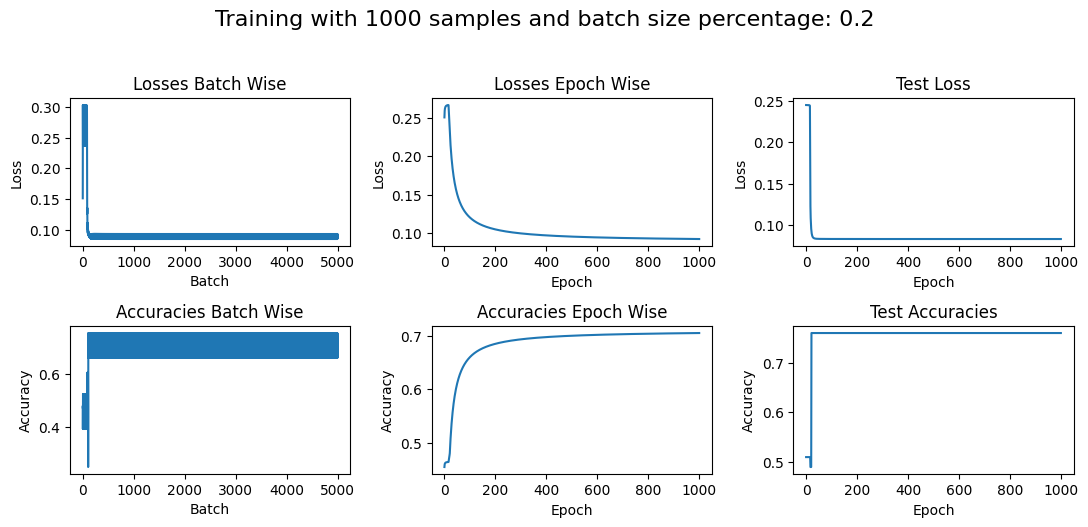

n = 1000, m = 0.2, Training Loss: 0.09248814189683251, Accuracy: 0.7049537499999999
n = 1000, m = 0.2, Test Loss: 0.08320949159169669, Accuracy: 0.76


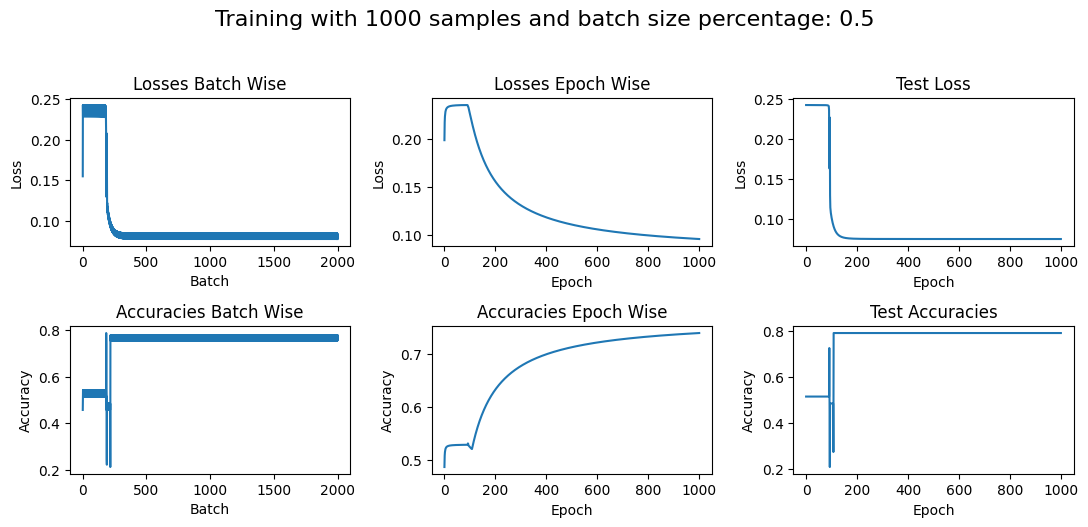

n = 1000, m = 0.5, Training Loss: 0.09608552958383094, Accuracy: 0.7394350000000002
n = 1000, m = 0.5, Test Loss: 0.07470754513310492, Accuracy: 0.79


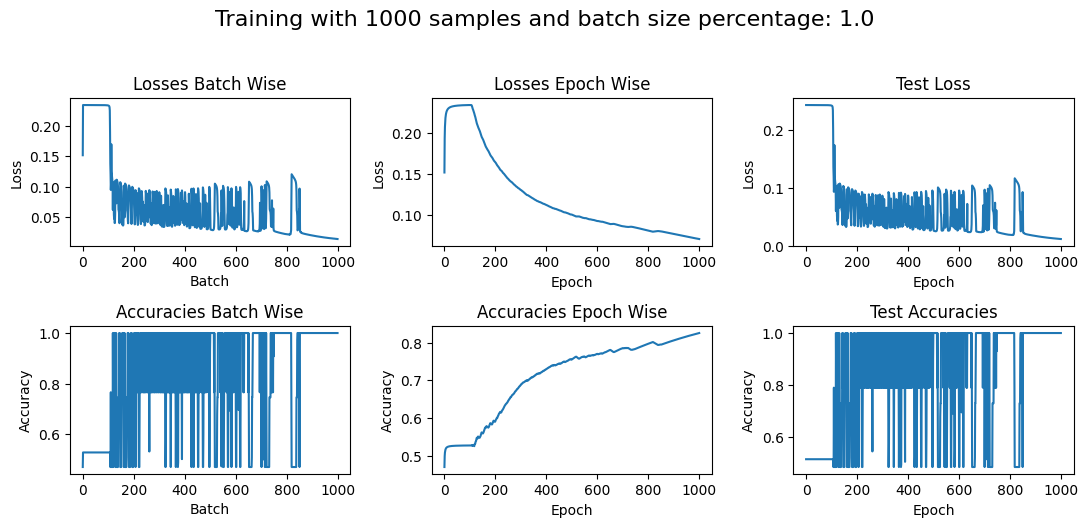

n = 1000, m = 1.0, Training Loss: 0.07065596098036442, Accuracy: 0.8251412499999999
n = 1000, m = 1.0, Test Loss: 0.011490072117577, Accuracy: 1.0


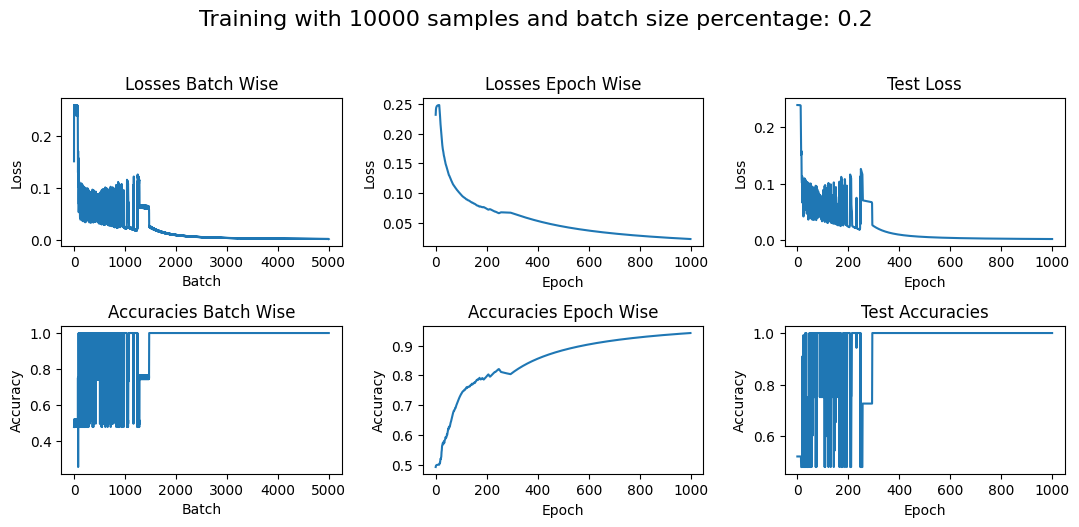

n = 10000, m = 0.2, Training Loss: 0.023336312968654908, Accuracy: 0.942385
n = 10000, m = 0.2, Test Loss: 0.0013011439318077825, Accuracy: 1.0


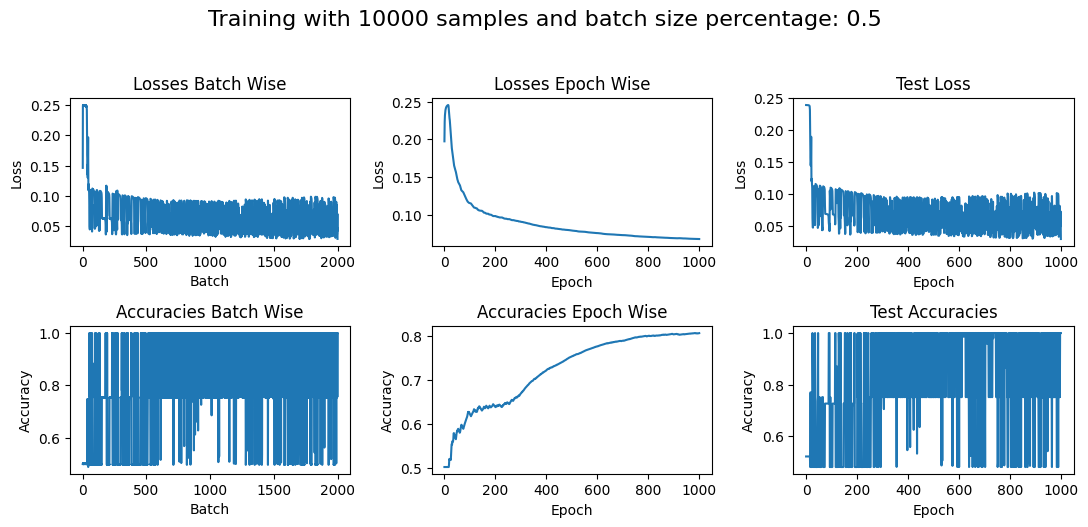

n = 10000, m = 0.5, Training Loss: 0.06773812490766888, Accuracy: 0.8072793749999999
n = 10000, m = 0.5, Test Loss: 0.02880770657638918, Accuracy: 1.0


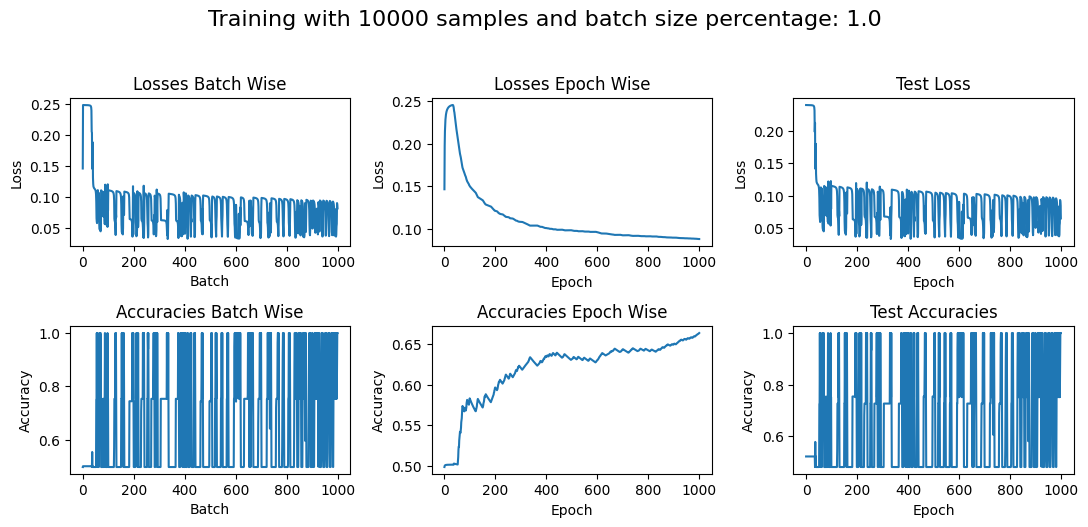

n = 10000, m = 1.0, Training Loss: 0.08794738199932783, Accuracy: 0.66340125
n = 10000, m = 1.0, Test Loss: 0.06495418322684429, Accuracy: 1.0


In [76]:
# varying number of training samples n
n_vals = [1000, 10000]
learning_rate = 150

# varying batch_sizes
batch_sizes_percentages = [0.2, 0.5, 1.0]

for i in n_vals:
    for j in batch_sizes_percentages:
        X_xor, y_xor = generate_xor_dataset(generate_data_points(i))
        ann = ANN(2, 2, 1)
        ann.train(X_xor, y_xor, 1000, learning_rate, j)
        plot_losses_accuracies(ann, i, j)
        print(f"n = {i}, m = {j}, Training Loss: {ann.losses_epoch_wise[-1]}, Accuracy: {ann.accuracies_epoch_wise[-1]}")
        print(f"n = {i}, m = {j}, Test Loss: {ann.loss_test[-1]}, Accuracy: {ann.accuracies_test[-1]}")

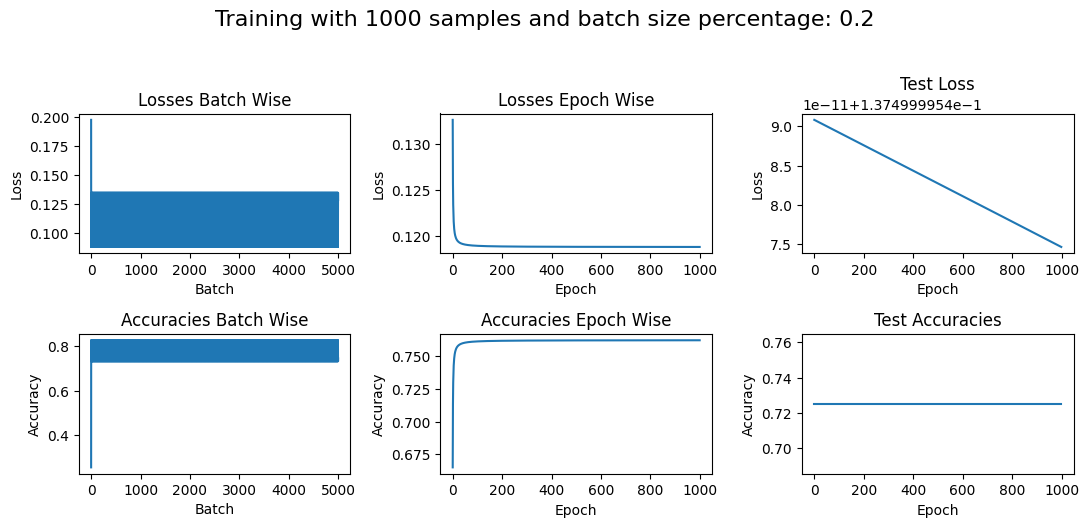

n = 1000, m = 0.2, Training Loss: 0.11876387701907438, Accuracy: 0.7624025000000001
n = 1000, m = 0.2, Test Loss: 0.13749999547459912, Accuracy: 0.725


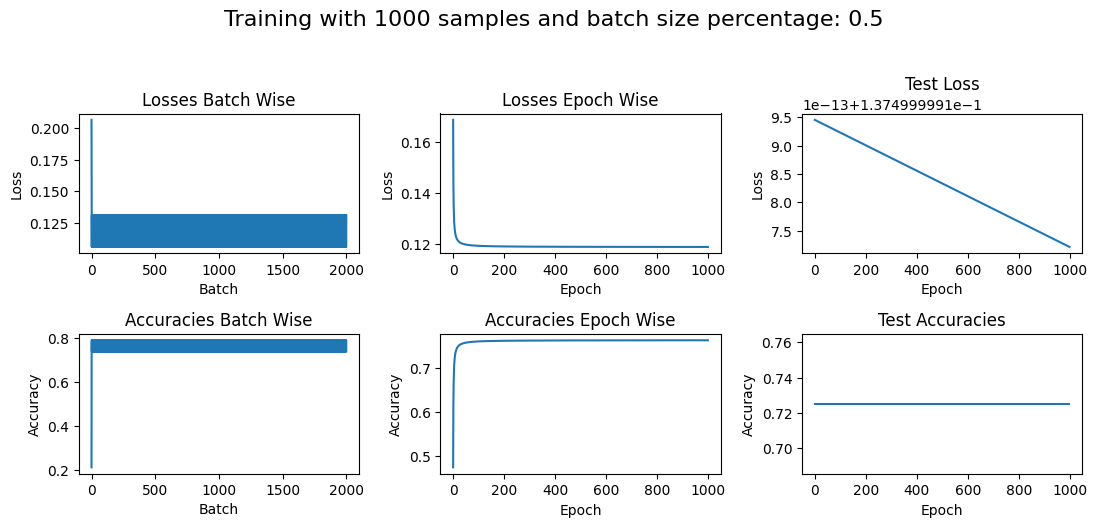

n = 1000, m = 0.5, Training Loss: 0.11880003706415213, Accuracy: 0.7622125
n = 1000, m = 0.5, Test Loss: 0.13749999914872166, Accuracy: 0.725


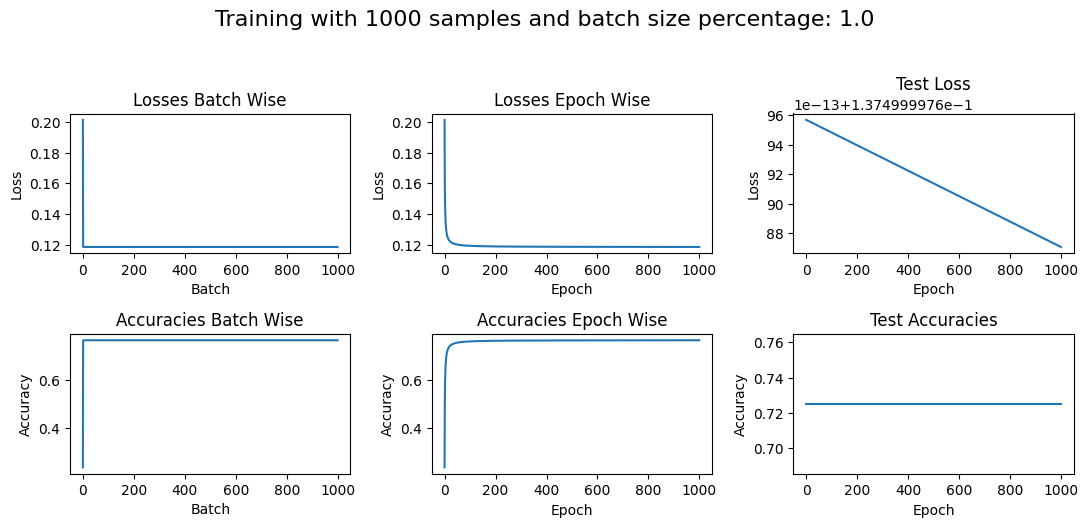

n = 1000, m = 1.0, Training Loss: 0.11883246750338465, Accuracy: 0.761975
n = 1000, m = 1.0, Test Loss: 0.1374999976187074, Accuracy: 0.725


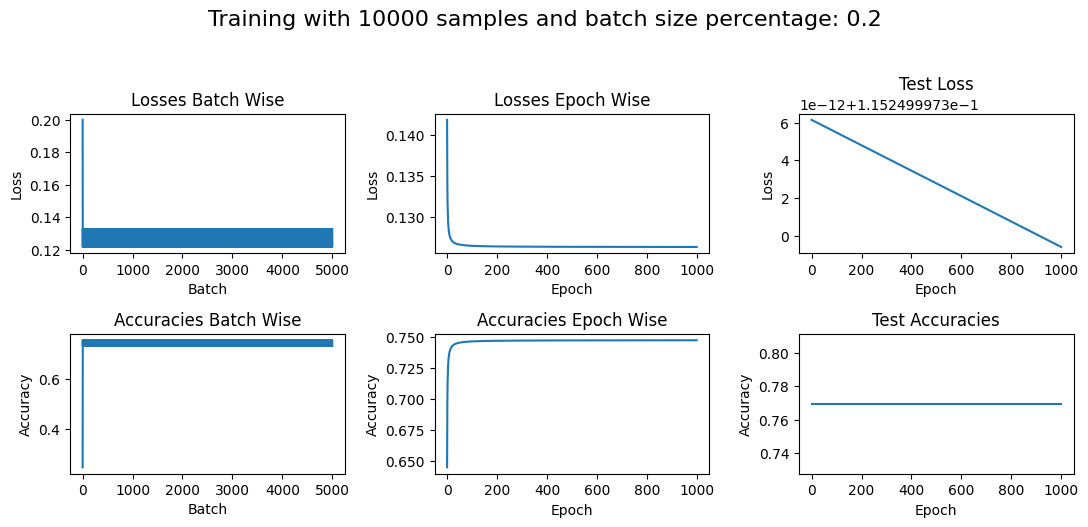

n = 10000, m = 0.2, Training Loss: 0.1263905233925273, Accuracy: 0.7471477499999999
n = 10000, m = 0.2, Test Loss: 0.11524999733942458, Accuracy: 0.7695


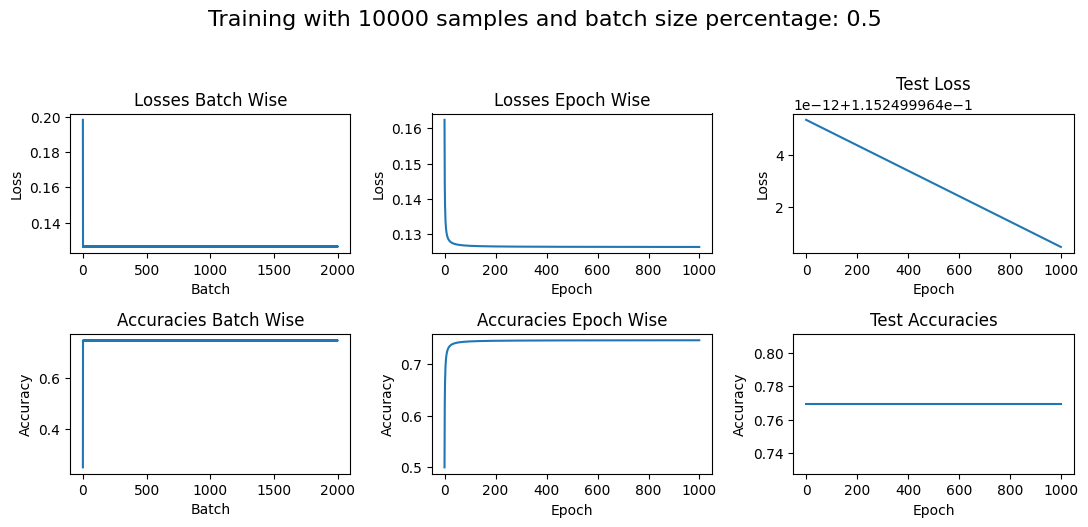

n = 10000, m = 0.5, Training Loss: 0.1264109884327285, Accuracy: 0.7470025000000001
n = 10000, m = 0.5, Test Loss: 0.11524999640046367, Accuracy: 0.7695


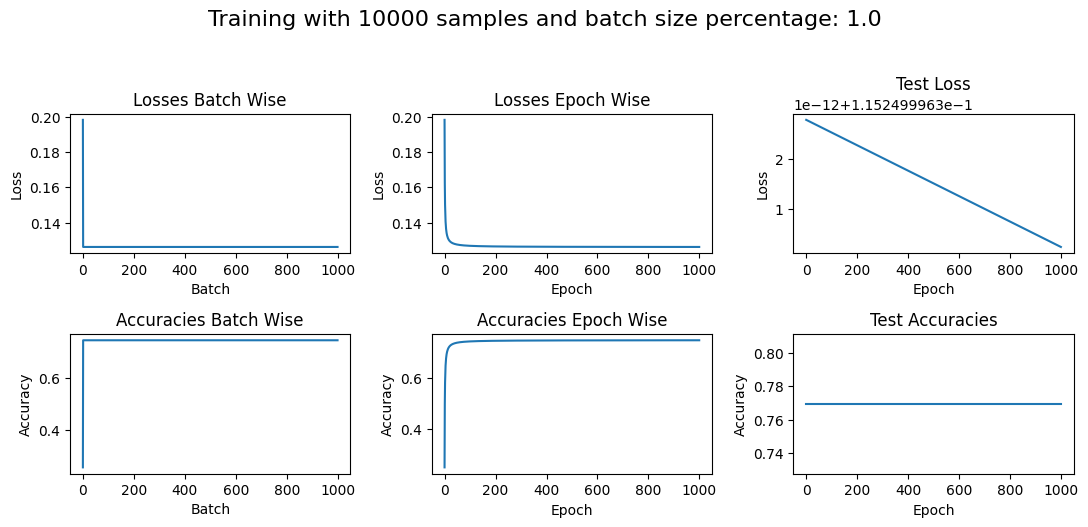

n = 10000, m = 1.0, Training Loss: 0.1264467968556087, Accuracy: 0.7467554999999999
n = 10000, m = 1.0, Test Loss: 0.1152499963502556, Accuracy: 0.7695


In [77]:
for i in n_vals:
    for j in batch_sizes_percentages:
        X_or, y_or = generate_or_dataset(generate_data_points(i))
        ann = ANN(2, 2, 1)
        ann.train(X_or, y_or, 1000, learning_rate, j)
        plot_losses_accuracies(ann, i, j)
        print(f"n = {i}, m = {j}, Training Loss: {ann.losses_epoch_wise[-1]}, Accuracy: {ann.accuracies_epoch_wise[-1]}")
        print(f"n = {i}, m = {j}, Test Loss: {ann.loss_test[-1]}, Accuracy: {ann.accuracies_test[-1]}")

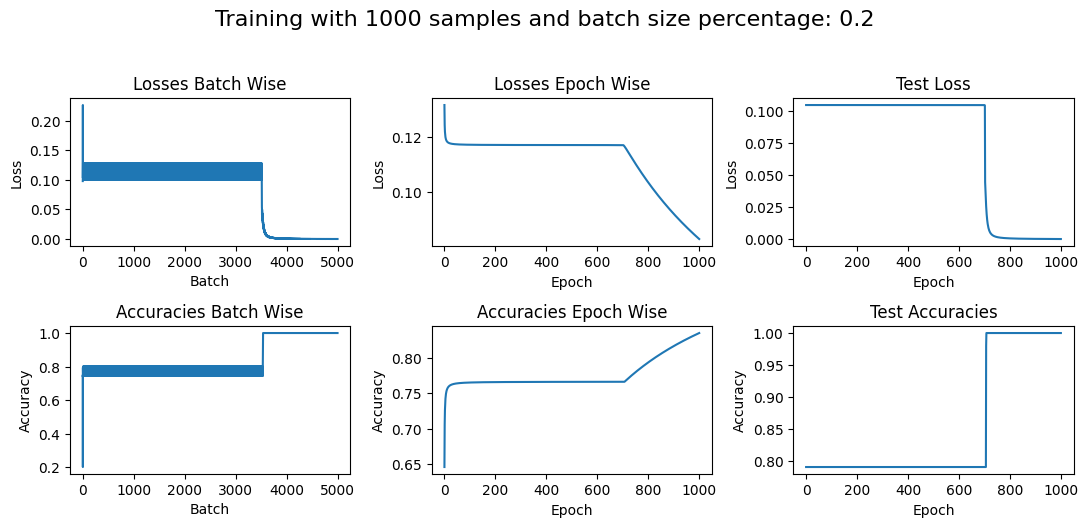

n = 1000, m = 0.2, Training Loss: 0.08274882011007137, Accuracy: 0.8346337500000002
n = 1000, m = 0.2, Test Loss: 0.00019542241181491813, Accuracy: 1.0


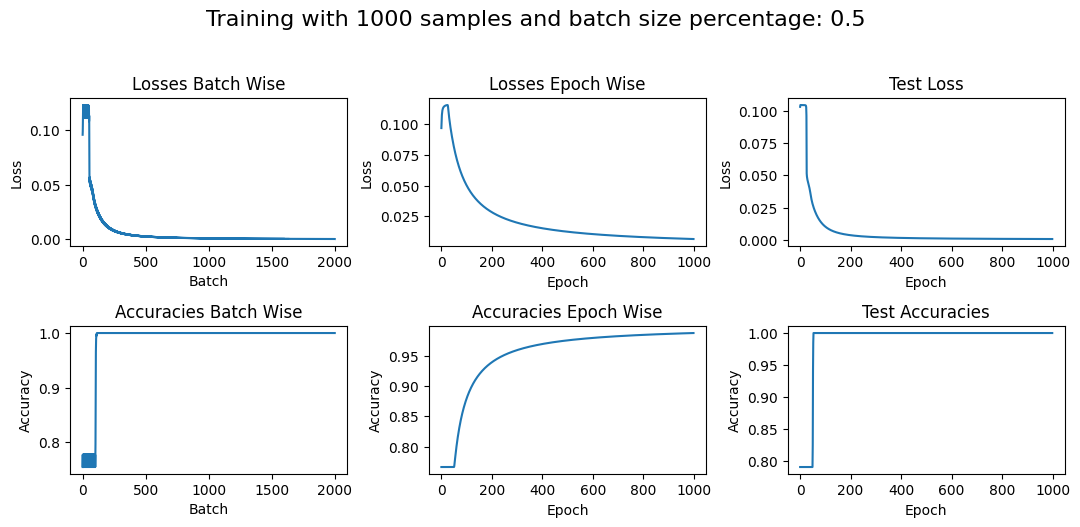

n = 1000, m = 0.5, Training Loss: 0.006629213823490745, Accuracy: 0.98784375
n = 1000, m = 0.5, Test Loss: 0.00040486382447308734, Accuracy: 1.0


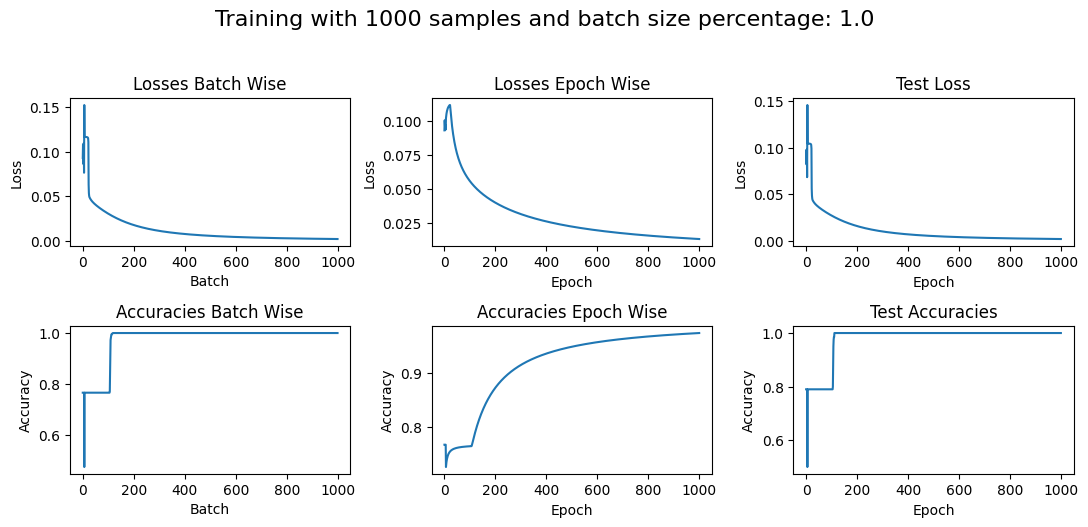

n = 1000, m = 1.0, Training Loss: 0.012896930231595634, Accuracy: 0.97440625
n = 1000, m = 1.0, Test Loss: 0.0021258862615965834, Accuracy: 1.0


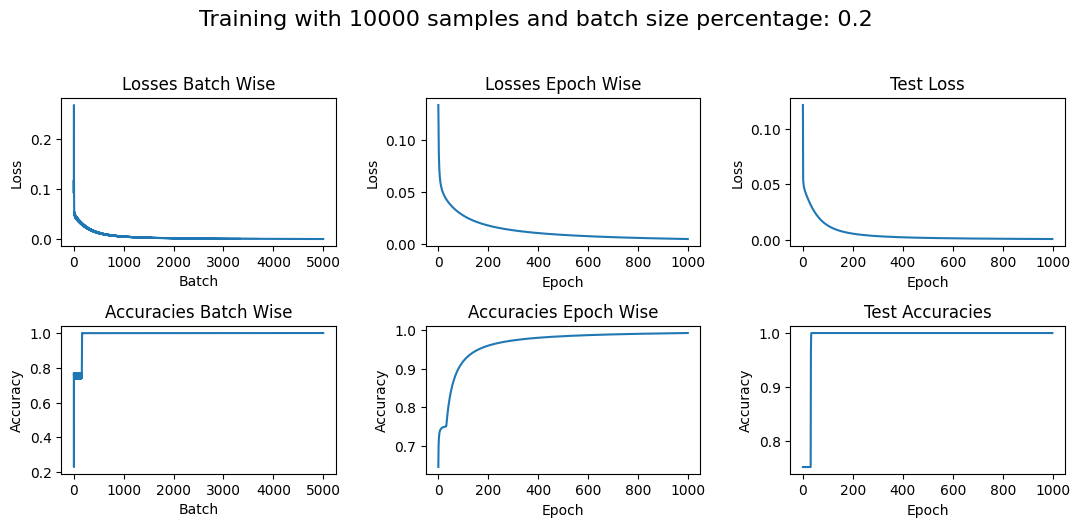

n = 10000, m = 0.2, Training Loss: 0.005061819737313679, Accuracy: 0.9918401249999999
n = 10000, m = 0.2, Test Loss: 0.0007520688133238041, Accuracy: 1.0


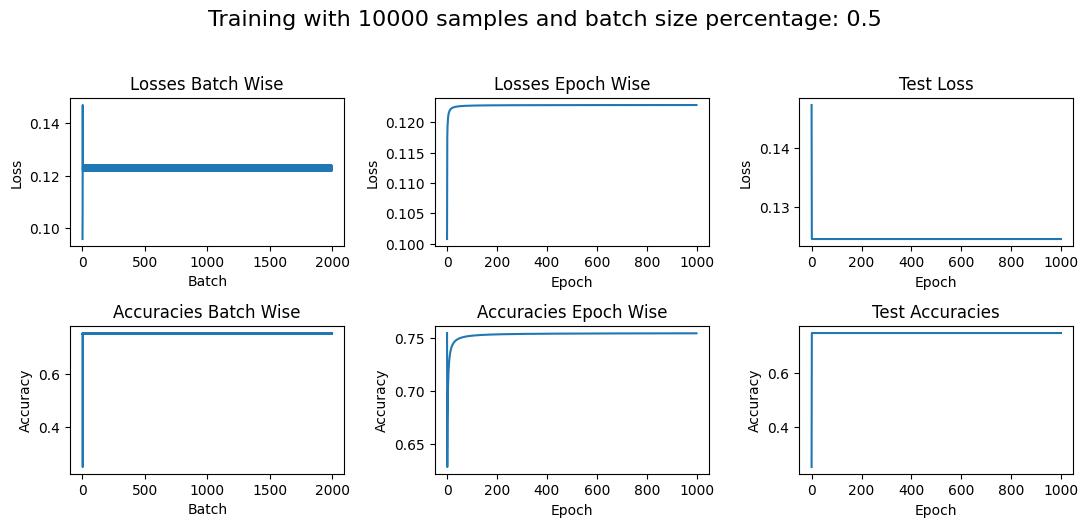

n = 10000, m = 0.5, Training Loss: 0.12286432395287188, Accuracy: 0.7539975
n = 10000, m = 0.5, Test Loss: 0.12449993368695698, Accuracy: 0.751


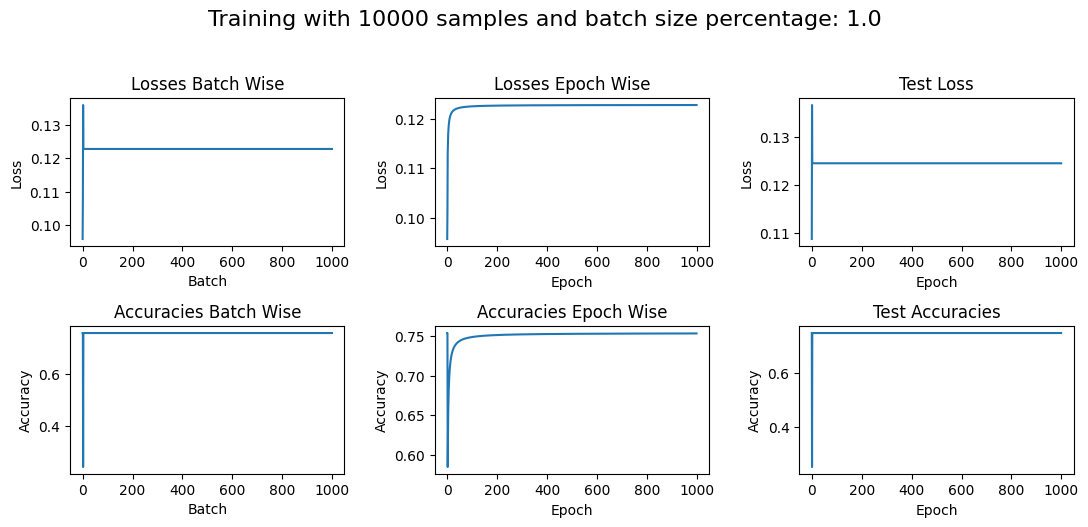

n = 10000, m = 1.0, Training Loss: 0.12284535978460814, Accuracy: 0.7537416250000001
n = 10000, m = 1.0, Test Loss: 0.12449984174387059, Accuracy: 0.751


In [78]:
for i in n_vals:
    for j in batch_sizes_percentages:
        X_and, y_and = generate_and_dataset(generate_data_points(i))
        ann = ANN(2, 2, 1)
        ann.train(X_and, y_and, 1000, learning_rate, j)
        plot_losses_accuracies(ann, i, j)
        print(f"n = {i}, m = {j}, Training Loss: {ann.losses_epoch_wise[-1]}, Accuracy: {ann.accuracies_epoch_wise[-1]}")
        print(f"n = {i}, m = {j}, Test Loss: {ann.loss_test[-1]}, Accuracy: {ann.accuracies_test[-1]}")

Most of the time, increasing the number of samples gives more accuracy. After experimenting, the conclusion there is no one-fit-for-all hyper-parameters. The learning rates which worked well for some datasets whereas caused lot of fluctuations in some others, which is demonstrated with above examples. However, as in real life, the more the data, the better.